Load the Python packages you'll need for running the code

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas 
import numpy as np
import xarray as xr
import xesmf

Open the model zooplankton dataset (same idea when we start using other model output)

In [2]:
ds = xr.open_dataset('/Users/lizdrenkard/external_data/Hollings_2020/zooplankton_data_luo.nc')

Check what's in the xarray dataset "ds"

In [3]:
ds

<xarray.Dataset>
Dimensions:           (TIME: 12, XT_OCEAN: 360, YT_OCEAN: 200, bnds: 2)
Coordinates:
  * XT_OCEAN          (XT_OCEAN) float64 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * YT_OCEAN          (YT_OCEAN) float64 -81.5 -80.5 -79.5 ... 87.5 88.5 89.5
  * TIME              (TIME) object 2007-01-16 12:00:00 ... 2007-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    YT_OCEAN_bnds     (YT_OCEAN, bnds) float64 ...
    TIME_bnds         (TIME, bnds) object ...
    SMALLZOO_BIOMASS  (TIME, YT_OCEAN, XT_OCEAN) float64 ...
    MEDZOO_BIOMASS    (TIME, YT_OCEAN, XT_OCEAN) float64 ...
    LARGEZOO_BIOMASS  (TIME, YT_OCEAN, XT_OCEAN) float64 ...
    SMALLZOO_PROD     (TIME, YT_OCEAN, XT_OCEAN) float64 ...
    MEDZOO_PROD       (TIME, YT_OCEAN, XT_OCEAN) float64 ...
    LARGEZOO_PROD     (TIME, YT_OCEAN, XT_OCEAN) float64 ...
    GEOLAT_T          (YT_OCEAN, XT_OCEAN) float32 ...
    GEOLON_T          (YT_OCEAN, XT_OCEAN) float32 ...
Attributes:
    history:      FERRET V6.85 (beta) 20-Oct-14
    Conventions:  CF-1.0

Open the Reef Site CSV file using pandas again

In [4]:
csv_fil = '/Users/lizdrenkard/TOOLS/Hollings_2020/ReefLocations.csv'
df = pandas.read_csv(csv_fil,encoding= 'unicode_escape')

Here, we're going to turn the pandas object, df into an Xarray so we can use it with the regridding package xesmf

In [5]:
rf_locs = xr.Dataset()
rf_locs['lon'] = xr.DataArray(data=df['LON'], dims=('reef_sites'))
rf_locs['lat'] = xr.DataArray(data=df['LAT'], dims=('reef_sites'))

Checkout what's in rf_locs

In [6]:
rf_locs

<xarray.Dataset>
Dimensions:     (reef_sites: 10048)
Coordinates:
  * reef_sites  (reef_sites) int64 0 1 2 3 4 5 ... 10043 10044 10045 10046 10047
Data variables:
    lon         (reef_sites) float64 -176.5 6.667 -82.95 ... 166.6 166.6 166.6
    lat         (reef_sites) float64 0.2167 0.03333 27.95 ... -13.25 -13.15

Create the geographic regridding weights 

In [7]:
regridder = xesmf.Regridder(ds.rename({'GEOLON_T': 'lon', 'GEOLAT_T': 'lat'}), rf_locs, 'bilinear', locstream_out=True)

Overwrite existing file: bilinear_200x360_1x10048.nc 
 You can set reuse_weights=True to save computing time.


Run the regridding for Total Zooplankton Biomass (i.e., Small + Medium + Large)

In [9]:
zpb_rf_locs = regridder((ds['SMALLZOO_BIOMASS']+ds['MEDZOO_BIOMASS']+ds['LARGEZOO_BIOMASS']))

With this configuration/input file you currently have 12 time points. We are going to chose just one for plotting

In [10]:
nmon = 6

Create a figure (here a histogram) to show the distribution of zooplankton productivity across reef sites

Text([4913.49188717], [2079.], '2007-07-16 12:00:00')

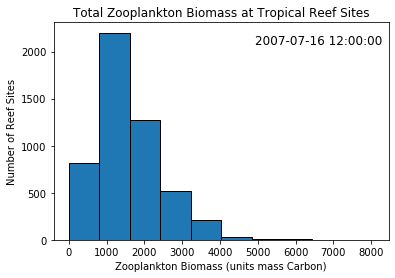

In [17]:
fid, ax =  plt.subplots()
zpb_rf_locs.isel(TIME=nmon).plot.hist(ax=ax,edgecolor='black')
# Putting some labels on the plot
ax.set_title('Total Zooplankton Biomass at Tropical Reef Sites')
ax.set_ylabel('Number of Reef Sites')
ax.set_xlabel('Zooplankton Biomass (units mass Carbon)')
# Putting the timestamp for this specific month on the plot
ax.text(ax.get_xlim()[1]-.4*(np.diff(ax.get_xlim())), ax.get_ylim()[1]-.1*(np.diff(ax.get_ylim())), zpb_rf_locs['TIME'].isel(TIME=nmon).values, fontsize=12)